# Statistical Analysis

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read file
df = pd.read_csv('scr_amg_hipp_all.csv')
df.head()

,sub,Condition,Event.Nr,CDA.AmpSum,expected_value,pe,scr,index,subject,trialNo,condition,coupling,amg,amg_vmpfc
0,sub-189,CSplusUS1,1,0.2852,0.773082,0.500000,0.2852,3036,sub-189,1,CSplusUS1,0.904762,0.476625,0.833333
1,sub-189,CSminus1,2,0.1033,0.770982,-0.500000,0.1033,3037,sub-189,2,CSminus1,-0.380952,0.081692,0.428571
2,sub-189,CSplus1,3,0.0783,0.772029,-0.500672,0.0783,3038,sub-189,3,CSplus1,0.571429,-0.219659,0.690476
3,sub-189,CSplusUS1,4,0.1772,0.773079,0.500002,0.1772,3039,sub-189,4,CSplusUS1,0.619048,0.006618,0.880952
4,sub-189,CSminus1,5,0.0000,0.769936,-0.499328,0.0000,3040,sub-189,5,CSminus1,0.833333,-0.188212,0.595238


In [22]:
# Run Pymc model
# Encode 'sub' as integer indices
df['sub_idx'] = pd.Categorical(df['sub']).codes
n_subs = df['sub_idx'].nunique()

# Extract variables
pe = df['pe'].values
coupling = df['coupling'].values
amg = df['amg'].values
trialNo = df['trialNo'].values
sub_idx = df['sub_idx'].values

with pm.Model() as model:
    
    # Fixed effects
    beta_coupling = pm.Normal('beta_coupling', mu=0, sigma=1)
    beta_amg = pm.Normal('beta_amg', mu=0, sigma=1)
    beta_trialNo = pm.Normal('beta_trialNo', mu=0, sigma=1)

    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sigma=1)
    sigma_a = pm.HalfNormal('sigma_a', sigma=1)

    # Non-centered random intercepts
    z_a = pm.Normal('z_a', mu=0, sigma=1, shape=n_subs)
    a = pm.Deterministic('a', mu_a + z_a * sigma_a)

    # Expected value of outcome
    mu = (
        a[sub_idx] +
        beta_coupling * coupling +
        beta_amg * amg +
        beta_trialNo * trialNo
    )
    
   
    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('pe', mu=mu, sigma=sigma, observed=pe)
    trace = pm.sample(chains=4, return_inferencedata=True,
                   idata_kwargs={"log_likelihood": True},
                  )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_coupling, beta_amg, beta_trialNo, mu_a, sigma_a, z_a, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [23]:
az.summary(trace, hdi_prob=.89,
          var_names=['beta_coupling'])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_coupling,0.09,0.02,0.057,0.122,0.0,0.0,3980.0,2504.0,1.0


In [56]:
az.summary(trace, hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_coupling,0.090,0.020,0.058,0.123,0.000,0.000,3287.0,2746.0,1.0
beta_amg,0.019,0.024,-0.020,0.057,0.000,0.000,5540.0,2648.0,1.0
beta_trialNo,0.001,0.000,0.001,0.002,0.000,0.000,3660.0,2966.0,1.0
mu_a,-0.186,0.017,-0.214,-0.160,0.000,0.000,2709.0,2292.0,1.0
z_a[0],0.090,0.933,-1.408,1.562,0.012,0.016,5686.0,2354.0,1.0
...,...,...,...,...,...,...,...,...,...
a[60],-0.177,0.025,-0.218,-0.139,0.000,0.000,2840.0,2410.0,1.0
a[61],-0.175,0.026,-0.216,-0.135,0.001,0.000,2681.0,2585.0,1.0
a[62],-0.175,0.026,-0.217,-0.137,0.001,0.001,3022.0,2031.0,1.0
a[63],-0.182,0.025,-0.221,-0.142,0.000,0.000,3411.0,2504.0,1.0


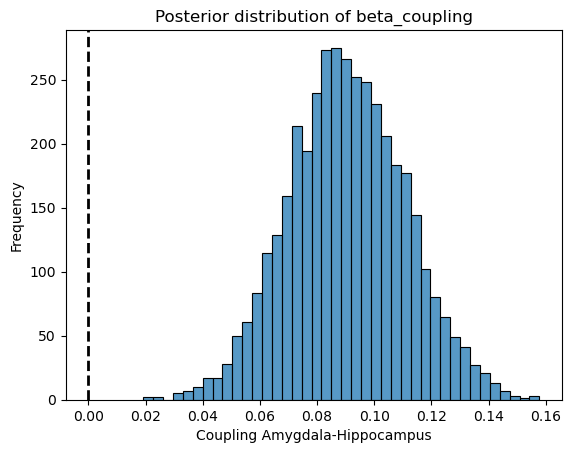

In [68]:
# stack beta coupling for all the chains
coupling = trace.posterior['beta_coupling'].stack(sample=("chain", "draw")).values
sns.histplot(coupling)
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.xlabel("Coupling Amygdala-Hippocampus")
plt.ylabel("Frequency")
plt.title("Posterior distribution of beta_coupling")
plt.show()

# VMPFC

In [24]:
# Extract variables
pe = df['pe'].values
coupling_vmpfc = df['amg_vmpfc'].values
amg = df['amg'].values
trialNo = df['trialNo'].values
sub_idx = df['sub_idx'].values

with pm.Model() as model:
    
    # Fixed effects
    beta_coupling = pm.Normal('beta_coupling', mu=0, sigma=1)
    beta_amg = pm.Normal('beta_amg', mu=0, sigma=1)
    beta_trialNo = pm.Normal('beta_trialNo', mu=0, sigma=1)

    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, sigma=1)
    sigma_a = pm.HalfNormal('sigma_a', sigma=1)

    # Non-centered random intercepts
    z_a = pm.Normal('z_a', mu=0, sigma=1, shape=n_subs)
    a = pm.Deterministic('a', mu_a + z_a * sigma_a)

    # Expected value of outcome
    mu = (
        a[sub_idx] +
        beta_coupling * coupling_vmpfc +
        beta_amg * amg +
        beta_trialNo * trialNo
    )

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=1)
    y_obs = pm.Normal('pe', mu=mu, sigma=sigma, observed=pe)
    trace_vmpfc = pm.sample(chains=4, return_inferencedata=True,
                   idata_kwargs={"log_likelihood": True},
                  )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_coupling, beta_amg, beta_trialNo, mu_a, sigma_a, z_a, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [25]:
az.summary(trace_vmpfc, hdi_prob=.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_coupling,-0.044,0.016,-0.073,-0.020,0.000,0.000,4305.0,2587.0,1.0
beta_amg,0.016,0.023,-0.018,0.057,0.000,0.000,5870.0,2720.0,1.0
beta_trialNo,0.001,0.000,0.001,0.002,0.000,0.000,4196.0,2679.0,1.0
mu_a,-0.123,0.013,-0.144,-0.101,0.000,0.000,3935.0,2489.0,1.0
z_a[0],-0.002,0.965,-1.476,1.549,0.013,0.017,5713.0,2850.0,1.0
...,...,...,...,...,...,...,...,...,...
a[60],-0.118,0.020,-0.150,-0.088,0.000,0.000,3449.0,2657.0,1.0
a[61],-0.118,0.020,-0.151,-0.089,0.000,0.000,4279.0,2805.0,1.0
a[62],-0.119,0.020,-0.154,-0.091,0.000,0.000,4057.0,2637.0,1.0
a[63],-0.120,0.019,-0.149,-0.090,0.000,0.000,3786.0,2857.0,1.0


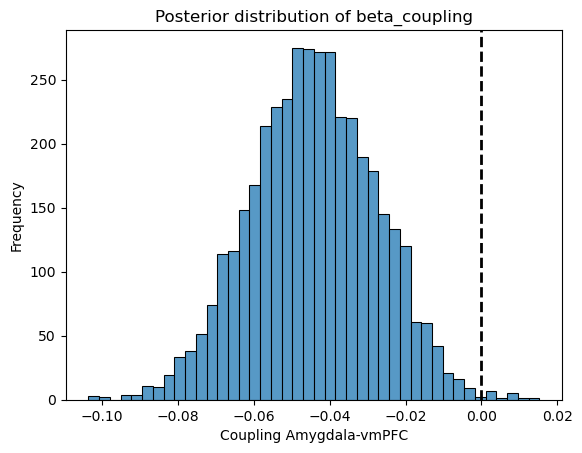

In [71]:
# stack beta coupling for all the chains
coupling = trace_vmpfc.posterior['beta_coupling'].stack(sample=("chain", "draw")).values
sns.histplot(coupling)
plt.axvline(0, color='black', linestyle='--', linewidth=2)
plt.xlabel("Coupling Amygdala-vmPFC")
plt.ylabel("Frequency")
plt.title("Posterior distribution of beta_coupling")
plt.show()

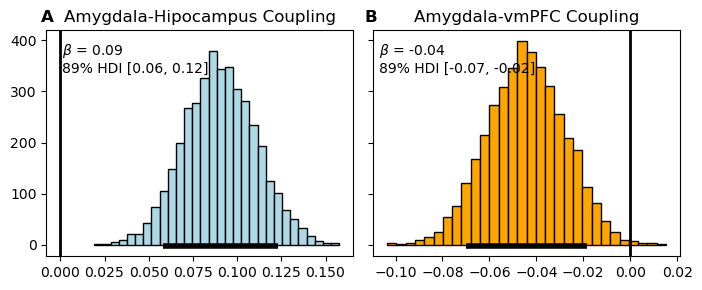

In [99]:
# nice plots
fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
data_1 = trace.posterior['beta_coupling'].values.flatten()
hpd_1 = az.hdi(data_1, hdi_prob=0.89)
mean_1 = data_1.mean()
low_1, high_1 = hpd_1
axes[0].hist(data_1, bins=30, color='lightblue', edgecolor='black')
axes[0].axvline(0, color='black', linestyle='-', linewidth=2)
axes[0].hlines(-2, hpd_1[0], hpd_1[1], color='black', linewidth=4)
axes[0].set_title("Amygdala-Hipocampus Coupling")

axes[0].text(
    0.05, 0.95,
    f"$\\beta$ = {mean_1:.2f}\n89% HDI [{low_1:.2f}, {high_1:.2f}]",
    transform=axes[0].transAxes,
    fontsize=10,
    ha='left',
    va='top',
    #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
)

data_2 = trace_vmpfc.posterior['beta_coupling'].values.flatten()
mean_2 = data_2.mean()
hpd_2 = az.hdi(data_2, hdi_prob=0.89)
low_2, high_2 = hpd_2

axes[1].hist(data_2, bins=30, color='orange', edgecolor='black')
axes[1].axvline(0, color='black', linestyle='-', linewidth=2)
axes[1].hlines(-2, hpd_2[0], hpd_2[1], color='black', linewidth=4)
axes[1].set_title("Amygdala-vmPFC Coupling")

axes[1].text(
    0.02, 0.95,
    f"$\\beta$ = {mean_2:.2f}\n89% HDI [{low_2:.2f}, {high_2:.2f}]",
    transform=axes[1].transAxes,
    fontsize=10,
    ha='left',
    va='top',
   # bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
)

# Define panel labels in row-major order (left to right, top to bottom)
panel_labels = ['A', 'B']
panel_coords = [
    (axes[0].get_position().x0-0.06, axes[0].get_position().y1 + 0.02),
    (axes[1].get_position().x0-0.02, axes[1].get_position().y1 + 0.02),
]
for label, (x, y) in zip(panel_labels, panel_coords):
    fig.text(x, y, label, fontsize=12, fontweight='bold', ha='left', va='bottom')
plt.tight_layout()
plt.savefig('fig_1.jpg', dpi=300)
plt.show()